# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [17]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

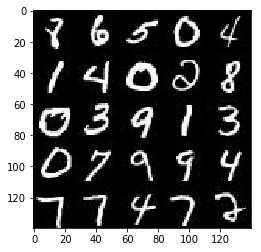

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

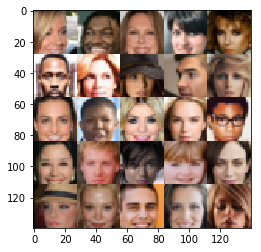

In [19]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/amir.k/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [21]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    return (tf.placeholder(tf.float32, [None, image_width, image_height, image_channels]), 
            tf.placeholder(tf.float32, [None, z_dim]), 
            tf.placeholder(tf.float32, None))


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [22]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        conv = tf.layers.conv2d(images, 64, 5, 2, 'same')
        conv = tf.maximum(conv * 0.2, conv)
        conv = tf.layers.conv2d(conv, 128, 5, 2, 'same')
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.maximum(conv * 0.2, conv)
        conv = tf.layers.conv2d(conv, 256, 5, 2, 'same')
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.maximum(conv * 0.2, conv)
        conv = tf.reshape(conv, (-1, 4096))
        conv = tf.layers.dense(conv, 1)
        return tf.sigmoid(conv), conv


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        conv = tf.layers.dense(z, 2048)
        conv = tf.reshape(conv, (-1, 2, 2, 512))
        conv = tf.maximum(conv * 0.2, conv)
        conv = tf.layers.conv2d_transpose(conv, 256, 5, 2, 'valid')
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(conv * 0.2, conv)
        conv = tf.layers.conv2d_transpose(conv, 128, 5, 2, 'same')
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(conv * 0.2, conv)
        conv = tf.layers.conv2d_transpose(conv, out_channel_dim, 5, 2, 'same')
        return tf.tanh(conv)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen = generator(input_z, out_channel_dim, True)
    disc, disc_logits = discriminator(input_real, False)
    disc_train, disc_train_logits = discriminator(gen, True)
    disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(disc), logits=disc_logits))
    disc_train_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(disc_train), logits=disc_train_logits))
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_train_logits, labels=tf.ones_like(disc_train)))
    return disc_loss + disc_train_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        trainable_variables = tf.trainable_variables()
        gen_vars = [variable for variable in trainable_variables if variable.name.startswith('generator')]
        disc_vars = [variable for variable in trainable_variables if variable.name.startswith('discriminator')]
        return (tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=gen_vars), 
                tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=disc_vars))


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.0000... Generator Loss: 21.0089
Epoch 1/2... Batch 20... Discriminator Loss: 0.0428... Generator Loss: 7.5084
Epoch 1/2... Batch 30... Discriminator Loss: 0.1023... Generator Loss: 9.0307
Epoch 1/2... Batch 40... Discriminator Loss: 0.4603... Generator Loss: 7.7776
Epoch 1/2... Batch 50... Discriminator Loss: 0.9061... Generator Loss: 6.2216
Epoch 1/2... Batch 60... Discriminator Loss: 0.0998... Generator Loss: 4.4553
Epoch 1/2... Batch 70... Discriminator Loss: 0.1245... Generator Loss: 7.6254
Epoch 1/2... Batch 80... Discriminator Loss: 0.1475... Generator Loss: 3.9319
Epoch 1/2... Batch 90... Discriminator Loss: 0.3721... Generator Loss: 2.9533
Epoch 1/2... Batch 100... Discriminator Loss: 0.0879... Generator Loss: 4.5401


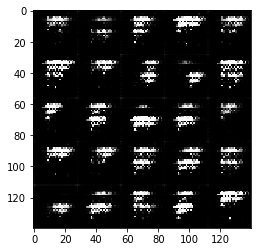

Epoch 1/2... Batch 110... Discriminator Loss: 2.9476... Generator Loss: 10.4269
Epoch 1/2... Batch 120... Discriminator Loss: 0.2635... Generator Loss: 4.3996
Epoch 1/2... Batch 130... Discriminator Loss: 0.1719... Generator Loss: 5.5642
Epoch 1/2... Batch 140... Discriminator Loss: 1.6530... Generator Loss: 11.2921
Epoch 1/2... Batch 150... Discriminator Loss: 0.0770... Generator Loss: 4.3891
Epoch 1/2... Batch 160... Discriminator Loss: 0.1857... Generator Loss: 5.3062
Epoch 1/2... Batch 170... Discriminator Loss: 0.1394... Generator Loss: 4.2567
Epoch 1/2... Batch 180... Discriminator Loss: 0.2181... Generator Loss: 3.2852
Epoch 1/2... Batch 190... Discriminator Loss: 0.1564... Generator Loss: 3.9824
Epoch 1/2... Batch 200... Discriminator Loss: 0.2195... Generator Loss: 6.3386


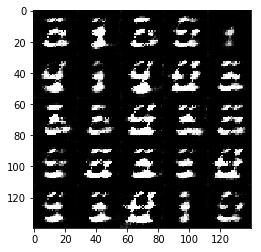

Epoch 1/2... Batch 210... Discriminator Loss: 0.1019... Generator Loss: 4.7693
Epoch 1/2... Batch 220... Discriminator Loss: 0.2397... Generator Loss: 2.9405
Epoch 1/2... Batch 230... Discriminator Loss: 0.4572... Generator Loss: 7.9774
Epoch 1/2... Batch 240... Discriminator Loss: 0.2774... Generator Loss: 3.7328
Epoch 1/2... Batch 250... Discriminator Loss: 0.1877... Generator Loss: 3.4131
Epoch 1/2... Batch 260... Discriminator Loss: 0.2226... Generator Loss: 3.9031
Epoch 1/2... Batch 270... Discriminator Loss: 0.2648... Generator Loss: 3.5965
Epoch 1/2... Batch 280... Discriminator Loss: 0.1903... Generator Loss: 3.1312
Epoch 1/2... Batch 290... Discriminator Loss: 0.2885... Generator Loss: 2.7937
Epoch 1/2... Batch 300... Discriminator Loss: 1.1164... Generator Loss: 6.4364


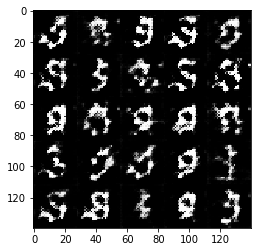

Epoch 1/2... Batch 310... Discriminator Loss: 0.4817... Generator Loss: 1.7898
Epoch 1/2... Batch 320... Discriminator Loss: 0.3026... Generator Loss: 5.0648
Epoch 1/2... Batch 330... Discriminator Loss: 0.4266... Generator Loss: 3.2984
Epoch 1/2... Batch 340... Discriminator Loss: 0.2496... Generator Loss: 3.2061
Epoch 1/2... Batch 350... Discriminator Loss: 0.3789... Generator Loss: 3.2031
Epoch 1/2... Batch 360... Discriminator Loss: 0.7123... Generator Loss: 3.4703
Epoch 1/2... Batch 370... Discriminator Loss: 0.2636... Generator Loss: 3.4984
Epoch 1/2... Batch 380... Discriminator Loss: 0.7163... Generator Loss: 4.4843
Epoch 1/2... Batch 390... Discriminator Loss: 0.4876... Generator Loss: 3.7964
Epoch 1/2... Batch 400... Discriminator Loss: 0.6765... Generator Loss: 1.3869


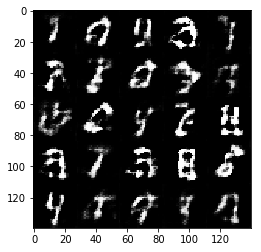

Epoch 1/2... Batch 410... Discriminator Loss: 0.2620... Generator Loss: 3.1746
Epoch 1/2... Batch 420... Discriminator Loss: 0.6086... Generator Loss: 3.4496
Epoch 1/2... Batch 430... Discriminator Loss: 0.3699... Generator Loss: 2.7100
Epoch 1/2... Batch 440... Discriminator Loss: 0.4437... Generator Loss: 1.5975
Epoch 1/2... Batch 450... Discriminator Loss: 0.6651... Generator Loss: 1.5802
Epoch 1/2... Batch 460... Discriminator Loss: 0.5916... Generator Loss: 3.7323
Epoch 2/2... Batch 10... Discriminator Loss: 0.4609... Generator Loss: 3.2050
Epoch 2/2... Batch 20... Discriminator Loss: 0.4208... Generator Loss: 3.4893
Epoch 2/2... Batch 30... Discriminator Loss: 0.3942... Generator Loss: 2.9958
Epoch 2/2... Batch 40... Discriminator Loss: 0.6237... Generator Loss: 3.8871
Epoch 2/2... Batch 50... Discriminator Loss: 0.7514... Generator Loss: 3.5549
Epoch 2/2... Batch 60... Discriminator Loss: 0.8400... Generator Loss: 3.3688
Epoch 2/2... Batch 70... Discriminator Loss: 0.6728... Gen

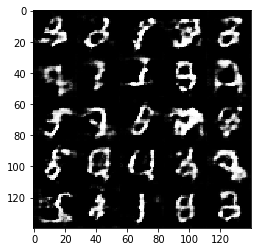

Epoch 2/2... Batch 110... Discriminator Loss: 0.6661... Generator Loss: 2.1891
Epoch 2/2... Batch 120... Discriminator Loss: 1.1013... Generator Loss: 3.6138
Epoch 2/2... Batch 130... Discriminator Loss: 0.8763... Generator Loss: 3.0704
Epoch 2/2... Batch 140... Discriminator Loss: 0.6088... Generator Loss: 1.2920
Epoch 2/2... Batch 150... Discriminator Loss: 0.5346... Generator Loss: 1.6357
Epoch 2/2... Batch 160... Discriminator Loss: 0.8317... Generator Loss: 3.2140
Epoch 2/2... Batch 170... Discriminator Loss: 0.6363... Generator Loss: 2.3585
Epoch 2/2... Batch 180... Discriminator Loss: 0.7650... Generator Loss: 0.9836
Epoch 2/2... Batch 190... Discriminator Loss: 0.8038... Generator Loss: 0.8782
Epoch 2/2... Batch 200... Discriminator Loss: 0.6820... Generator Loss: 2.7178


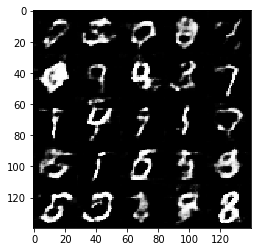

Epoch 2/2... Batch 210... Discriminator Loss: 0.9780... Generator Loss: 0.8472
Epoch 2/2... Batch 220... Discriminator Loss: 0.7359... Generator Loss: 1.1704
Epoch 2/2... Batch 230... Discriminator Loss: 0.4561... Generator Loss: 1.7571
Epoch 2/2... Batch 240... Discriminator Loss: 1.2465... Generator Loss: 4.2619
Epoch 2/2... Batch 250... Discriminator Loss: 0.7530... Generator Loss: 1.1405
Epoch 2/2... Batch 260... Discriminator Loss: 0.6009... Generator Loss: 2.0112
Epoch 2/2... Batch 270... Discriminator Loss: 1.3681... Generator Loss: 4.3668
Epoch 2/2... Batch 280... Discriminator Loss: 0.5691... Generator Loss: 1.8400
Epoch 2/2... Batch 290... Discriminator Loss: 0.8845... Generator Loss: 3.6447
Epoch 2/2... Batch 300... Discriminator Loss: 0.8640... Generator Loss: 0.9045


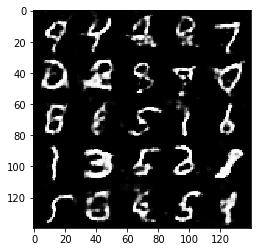

Epoch 2/2... Batch 310... Discriminator Loss: 0.6653... Generator Loss: 1.8840
Epoch 2/2... Batch 320... Discriminator Loss: 0.5421... Generator Loss: 2.0208
Epoch 2/2... Batch 330... Discriminator Loss: 0.4742... Generator Loss: 2.2399
Epoch 2/2... Batch 340... Discriminator Loss: 0.8698... Generator Loss: 3.2970
Epoch 2/2... Batch 350... Discriminator Loss: 1.0489... Generator Loss: 1.9282
Epoch 2/2... Batch 360... Discriminator Loss: 0.5863... Generator Loss: 1.9002
Epoch 2/2... Batch 370... Discriminator Loss: 0.6723... Generator Loss: 2.6715
Epoch 2/2... Batch 380... Discriminator Loss: 0.9941... Generator Loss: 3.0017
Epoch 2/2... Batch 390... Discriminator Loss: 0.6658... Generator Loss: 2.3883
Epoch 2/2... Batch 400... Discriminator Loss: 0.7549... Generator Loss: 0.8900


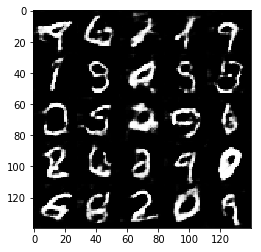

Epoch 2/2... Batch 410... Discriminator Loss: 0.6517... Generator Loss: 1.6627
Epoch 2/2... Batch 420... Discriminator Loss: 0.5686... Generator Loss: 2.0284
Epoch 2/2... Batch 430... Discriminator Loss: 0.5886... Generator Loss: 3.0880
Epoch 2/2... Batch 440... Discriminator Loss: 0.6690... Generator Loss: 1.5393
Epoch 2/2... Batch 450... Discriminator Loss: 0.6680... Generator Loss: 1.2006
Epoch 2/2... Batch 460... Discriminator Loss: 0.6183... Generator Loss: 1.1683


In [28]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.5696... Generator Loss: 3.5105
Epoch 1/1... Batch 20... Discriminator Loss: 0.5823... Generator Loss: 5.0325
Epoch 1/1... Batch 30... Discriminator Loss: 0.3978... Generator Loss: 5.3622
Epoch 1/1... Batch 40... Discriminator Loss: 0.2747... Generator Loss: 4.9141
Epoch 1/1... Batch 50... Discriminator Loss: 0.2484... Generator Loss: 4.7771
Epoch 1/1... Batch 60... Discriminator Loss: 0.1845... Generator Loss: 4.7102
Epoch 1/1... Batch 70... Discriminator Loss: 0.2052... Generator Loss: 4.2831
Epoch 1/1... Batch 80... Discriminator Loss: 0.1905... Generator Loss: 4.5302
Epoch 1/1... Batch 90... Discriminator Loss: 0.2241... Generator Loss: 4.9040
Epoch 1/1... Batch 100... Discriminator Loss: 0.1332... Generator Loss: 4.7435


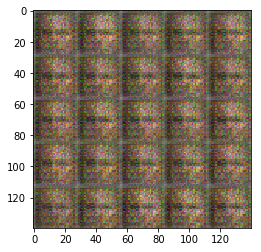

Epoch 1/1... Batch 110... Discriminator Loss: 0.1016... Generator Loss: 4.4394
Epoch 1/1... Batch 120... Discriminator Loss: 0.2173... Generator Loss: 5.2571
Epoch 1/1... Batch 130... Discriminator Loss: 0.3157... Generator Loss: 6.9192
Epoch 1/1... Batch 140... Discriminator Loss: 0.1115... Generator Loss: 4.4720
Epoch 1/1... Batch 150... Discriminator Loss: 0.1078... Generator Loss: 5.1383
Epoch 1/1... Batch 160... Discriminator Loss: 0.0658... Generator Loss: 5.3156
Epoch 1/1... Batch 170... Discriminator Loss: 0.1134... Generator Loss: 4.8467
Epoch 1/1... Batch 180... Discriminator Loss: 0.1496... Generator Loss: 5.7771
Epoch 1/1... Batch 190... Discriminator Loss: 0.1178... Generator Loss: 5.2633
Epoch 1/1... Batch 200... Discriminator Loss: 0.0666... Generator Loss: 4.9023


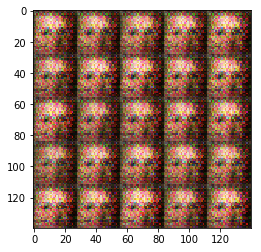

Epoch 1/1... Batch 210... Discriminator Loss: 0.0709... Generator Loss: 5.7714
Epoch 1/1... Batch 220... Discriminator Loss: 0.0833... Generator Loss: 5.1545
Epoch 1/1... Batch 230... Discriminator Loss: 0.0754... Generator Loss: 5.1213
Epoch 1/1... Batch 240... Discriminator Loss: 0.0755... Generator Loss: 5.3117
Epoch 1/1... Batch 250... Discriminator Loss: 0.0729... Generator Loss: 5.1711
Epoch 1/1... Batch 260... Discriminator Loss: 0.0439... Generator Loss: 5.0749
Epoch 1/1... Batch 270... Discriminator Loss: 0.0603... Generator Loss: 5.4602
Epoch 1/1... Batch 280... Discriminator Loss: 0.0503... Generator Loss: 5.0519
Epoch 1/1... Batch 290... Discriminator Loss: 0.0371... Generator Loss: 5.2048
Epoch 1/1... Batch 300... Discriminator Loss: 0.0756... Generator Loss: 5.2183


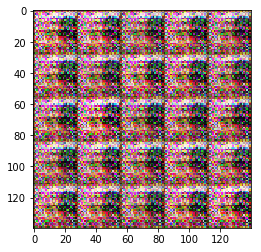

Epoch 1/1... Batch 310... Discriminator Loss: 0.0313... Generator Loss: 5.0887
Epoch 1/1... Batch 320... Discriminator Loss: 0.0590... Generator Loss: 5.2250
Epoch 1/1... Batch 330... Discriminator Loss: 0.0702... Generator Loss: 5.0702
Epoch 1/1... Batch 340... Discriminator Loss: 0.1474... Generator Loss: 6.7342
Epoch 1/1... Batch 350... Discriminator Loss: 0.0872... Generator Loss: 5.9362
Epoch 1/1... Batch 360... Discriminator Loss: 0.0850... Generator Loss: 4.4567
Epoch 1/1... Batch 370... Discriminator Loss: 0.3196... Generator Loss: 6.5803
Epoch 1/1... Batch 380... Discriminator Loss: 0.3216... Generator Loss: 2.8041
Epoch 1/1... Batch 390... Discriminator Loss: 0.2167... Generator Loss: 2.2024
Epoch 1/1... Batch 400... Discriminator Loss: 0.1382... Generator Loss: 3.4335


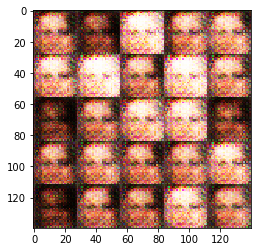

Epoch 1/1... Batch 410... Discriminator Loss: 0.2506... Generator Loss: 4.4639
Epoch 1/1... Batch 420... Discriminator Loss: 0.1256... Generator Loss: 4.8579
Epoch 1/1... Batch 430... Discriminator Loss: 0.1587... Generator Loss: 2.7904
Epoch 1/1... Batch 440... Discriminator Loss: 0.0781... Generator Loss: 3.2225
Epoch 1/1... Batch 450... Discriminator Loss: 0.2577... Generator Loss: 3.4363
Epoch 1/1... Batch 460... Discriminator Loss: 0.2376... Generator Loss: 3.9234
Epoch 1/1... Batch 470... Discriminator Loss: 0.3997... Generator Loss: 3.8043
Epoch 1/1... Batch 480... Discriminator Loss: 0.2288... Generator Loss: 3.1340
Epoch 1/1... Batch 490... Discriminator Loss: 0.1428... Generator Loss: 4.0623
Epoch 1/1... Batch 500... Discriminator Loss: 0.2471... Generator Loss: 3.5955


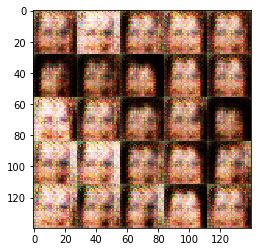

Epoch 1/1... Batch 510... Discriminator Loss: 0.5273... Generator Loss: 5.3053
Epoch 1/1... Batch 520... Discriminator Loss: 0.4134... Generator Loss: 2.0441
Epoch 1/1... Batch 530... Discriminator Loss: 0.4459... Generator Loss: 4.6560
Epoch 1/1... Batch 540... Discriminator Loss: 0.2904... Generator Loss: 3.3056
Epoch 1/1... Batch 550... Discriminator Loss: 0.2886... Generator Loss: 3.4591
Epoch 1/1... Batch 560... Discriminator Loss: 0.7332... Generator Loss: 4.1357
Epoch 1/1... Batch 570... Discriminator Loss: 0.3968... Generator Loss: 4.0843
Epoch 1/1... Batch 580... Discriminator Loss: 0.2196... Generator Loss: 2.7457
Epoch 1/1... Batch 590... Discriminator Loss: 0.5081... Generator Loss: 4.7788
Epoch 1/1... Batch 600... Discriminator Loss: 0.3424... Generator Loss: 1.9884


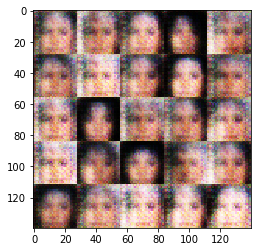

Epoch 1/1... Batch 610... Discriminator Loss: 0.3613... Generator Loss: 3.3784
Epoch 1/1... Batch 620... Discriminator Loss: 0.4411... Generator Loss: 1.6537
Epoch 1/1... Batch 630... Discriminator Loss: 0.4352... Generator Loss: 3.9399
Epoch 1/1... Batch 640... Discriminator Loss: 0.4128... Generator Loss: 3.3537
Epoch 1/1... Batch 650... Discriminator Loss: 0.3812... Generator Loss: 2.9732
Epoch 1/1... Batch 660... Discriminator Loss: 0.2956... Generator Loss: 2.6716
Epoch 1/1... Batch 670... Discriminator Loss: 0.5980... Generator Loss: 2.9650
Epoch 1/1... Batch 680... Discriminator Loss: 0.6206... Generator Loss: 1.4689
Epoch 1/1... Batch 690... Discriminator Loss: 0.4596... Generator Loss: 2.3203
Epoch 1/1... Batch 700... Discriminator Loss: 0.4577... Generator Loss: 2.4415


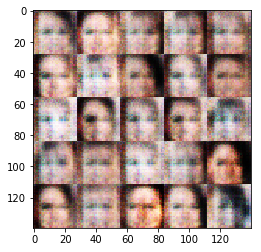

Epoch 1/1... Batch 710... Discriminator Loss: 0.9515... Generator Loss: 0.9516
Epoch 1/1... Batch 720... Discriminator Loss: 0.5504... Generator Loss: 1.8379
Epoch 1/1... Batch 730... Discriminator Loss: 0.5321... Generator Loss: 2.0190
Epoch 1/1... Batch 740... Discriminator Loss: 0.4943... Generator Loss: 1.9072
Epoch 1/1... Batch 750... Discriminator Loss: 0.5404... Generator Loss: 1.8280
Epoch 1/1... Batch 760... Discriminator Loss: 0.5282... Generator Loss: 2.1589
Epoch 1/1... Batch 770... Discriminator Loss: 0.4893... Generator Loss: 1.8819
Epoch 1/1... Batch 780... Discriminator Loss: 0.7659... Generator Loss: 2.0951
Epoch 1/1... Batch 790... Discriminator Loss: 0.5947... Generator Loss: 3.0123
Epoch 1/1... Batch 800... Discriminator Loss: 0.7424... Generator Loss: 2.3850


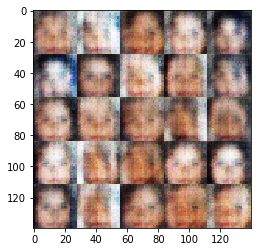

Epoch 1/1... Batch 810... Discriminator Loss: 0.6335... Generator Loss: 1.5484
Epoch 1/1... Batch 820... Discriminator Loss: 0.8586... Generator Loss: 3.4619
Epoch 1/1... Batch 830... Discriminator Loss: 0.6420... Generator Loss: 1.8855
Epoch 1/1... Batch 840... Discriminator Loss: 0.5847... Generator Loss: 1.9549
Epoch 1/1... Batch 850... Discriminator Loss: 0.7058... Generator Loss: 2.1644
Epoch 1/1... Batch 860... Discriminator Loss: 0.6855... Generator Loss: 2.2044
Epoch 1/1... Batch 870... Discriminator Loss: 0.4439... Generator Loss: 2.8542
Epoch 1/1... Batch 880... Discriminator Loss: 0.5143... Generator Loss: 3.2490
Epoch 1/1... Batch 890... Discriminator Loss: 0.5104... Generator Loss: 2.3670
Epoch 1/1... Batch 900... Discriminator Loss: 0.5214... Generator Loss: 1.9467


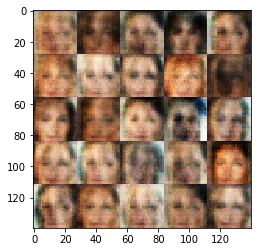

Epoch 1/1... Batch 910... Discriminator Loss: 0.6633... Generator Loss: 2.0291
Epoch 1/1... Batch 920... Discriminator Loss: 0.4592... Generator Loss: 1.9064
Epoch 1/1... Batch 930... Discriminator Loss: 0.7039... Generator Loss: 1.9041
Epoch 1/1... Batch 940... Discriminator Loss: 0.6507... Generator Loss: 1.3166
Epoch 1/1... Batch 950... Discriminator Loss: 0.8247... Generator Loss: 2.5949
Epoch 1/1... Batch 960... Discriminator Loss: 0.4844... Generator Loss: 2.1434
Epoch 1/1... Batch 970... Discriminator Loss: 0.5352... Generator Loss: 2.0234
Epoch 1/1... Batch 980... Discriminator Loss: 0.6473... Generator Loss: 1.4374
Epoch 1/1... Batch 990... Discriminator Loss: 0.7281... Generator Loss: 2.7822
Epoch 1/1... Batch 1000... Discriminator Loss: 0.3983... Generator Loss: 2.9210


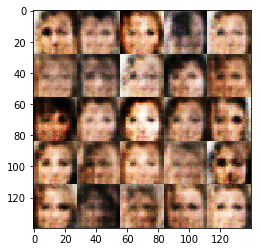

Epoch 1/1... Batch 1010... Discriminator Loss: 0.5749... Generator Loss: 2.3512
Epoch 1/1... Batch 1020... Discriminator Loss: 0.6841... Generator Loss: 1.3442
Epoch 1/1... Batch 1030... Discriminator Loss: 0.5491... Generator Loss: 1.9476
Epoch 1/1... Batch 1040... Discriminator Loss: 0.7281... Generator Loss: 2.5351
Epoch 1/1... Batch 1050... Discriminator Loss: 0.5877... Generator Loss: 2.0360
Epoch 1/1... Batch 1060... Discriminator Loss: 0.6238... Generator Loss: 1.9395
Epoch 1/1... Batch 1070... Discriminator Loss: 0.6461... Generator Loss: 1.6892
Epoch 1/1... Batch 1080... Discriminator Loss: 0.5735... Generator Loss: 1.7780
Epoch 1/1... Batch 1090... Discriminator Loss: 0.7244... Generator Loss: 2.0894
Epoch 1/1... Batch 1100... Discriminator Loss: 0.6715... Generator Loss: 1.5028


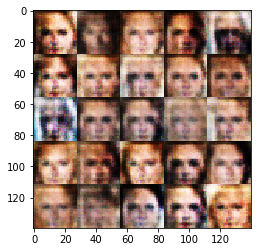

Epoch 1/1... Batch 1110... Discriminator Loss: 0.5362... Generator Loss: 2.1336
Epoch 1/1... Batch 1120... Discriminator Loss: 0.6080... Generator Loss: 1.6908
Epoch 1/1... Batch 1130... Discriminator Loss: 0.6160... Generator Loss: 1.7756
Epoch 1/1... Batch 1140... Discriminator Loss: 0.6948... Generator Loss: 1.8419
Epoch 1/1... Batch 1150... Discriminator Loss: 0.6909... Generator Loss: 2.3008
Epoch 1/1... Batch 1160... Discriminator Loss: 0.6340... Generator Loss: 2.0015
Epoch 1/1... Batch 1170... Discriminator Loss: 0.6495... Generator Loss: 2.0574
Epoch 1/1... Batch 1180... Discriminator Loss: 0.5813... Generator Loss: 1.7227
Epoch 1/1... Batch 1190... Discriminator Loss: 0.5521... Generator Loss: 1.9371
Epoch 1/1... Batch 1200... Discriminator Loss: 0.5779... Generator Loss: 2.2870


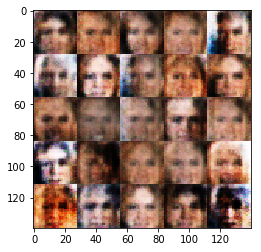

Epoch 1/1... Batch 1210... Discriminator Loss: 0.9125... Generator Loss: 2.1537
Epoch 1/1... Batch 1220... Discriminator Loss: 0.6395... Generator Loss: 2.0691
Epoch 1/1... Batch 1230... Discriminator Loss: 0.5948... Generator Loss: 1.7611
Epoch 1/1... Batch 1240... Discriminator Loss: 0.8989... Generator Loss: 1.9988
Epoch 1/1... Batch 1250... Discriminator Loss: 0.5813... Generator Loss: 1.8007
Epoch 1/1... Batch 1260... Discriminator Loss: 0.8884... Generator Loss: 2.1781
Epoch 1/1... Batch 1270... Discriminator Loss: 0.6982... Generator Loss: 1.6733
Epoch 1/1... Batch 1280... Discriminator Loss: 0.6618... Generator Loss: 2.0600
Epoch 1/1... Batch 1290... Discriminator Loss: 0.5634... Generator Loss: 2.2939
Epoch 1/1... Batch 1300... Discriminator Loss: 0.5899... Generator Loss: 2.0157


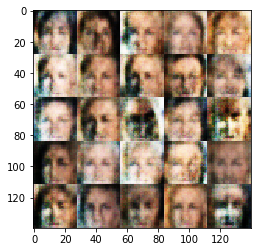

Epoch 1/1... Batch 1310... Discriminator Loss: 0.7717... Generator Loss: 2.4768
Epoch 1/1... Batch 1320... Discriminator Loss: 0.7885... Generator Loss: 1.1953
Epoch 1/1... Batch 1330... Discriminator Loss: 0.6746... Generator Loss: 1.9257
Epoch 1/1... Batch 1340... Discriminator Loss: 0.7863... Generator Loss: 2.0894
Epoch 1/1... Batch 1350... Discriminator Loss: 0.5606... Generator Loss: 1.7646
Epoch 1/1... Batch 1360... Discriminator Loss: 0.7904... Generator Loss: 1.2234
Epoch 1/1... Batch 1370... Discriminator Loss: 0.7276... Generator Loss: 2.1513
Epoch 1/1... Batch 1380... Discriminator Loss: 0.7927... Generator Loss: 1.4845
Epoch 1/1... Batch 1390... Discriminator Loss: 0.8491... Generator Loss: 1.6244
Epoch 1/1... Batch 1400... Discriminator Loss: 0.5688... Generator Loss: 1.9180


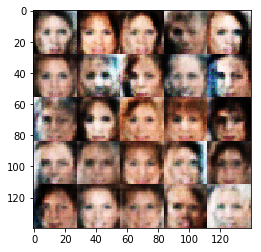

Epoch 1/1... Batch 1410... Discriminator Loss: 0.7704... Generator Loss: 1.5293
Epoch 1/1... Batch 1420... Discriminator Loss: 0.6432... Generator Loss: 2.1287
Epoch 1/1... Batch 1430... Discriminator Loss: 0.7128... Generator Loss: 2.2856
Epoch 1/1... Batch 1440... Discriminator Loss: 0.6846... Generator Loss: 1.4290
Epoch 1/1... Batch 1450... Discriminator Loss: 0.7451... Generator Loss: 1.9273
Epoch 1/1... Batch 1460... Discriminator Loss: 0.6091... Generator Loss: 2.5463
Epoch 1/1... Batch 1470... Discriminator Loss: 0.7111... Generator Loss: 1.2522
Epoch 1/1... Batch 1480... Discriminator Loss: 0.6802... Generator Loss: 2.0515
Epoch 1/1... Batch 1490... Discriminator Loss: 0.7720... Generator Loss: 1.4916
Epoch 1/1... Batch 1500... Discriminator Loss: 0.6850... Generator Loss: 2.0205


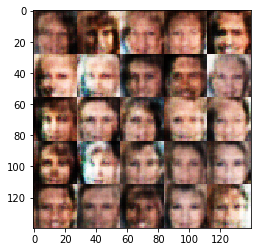

Epoch 1/1... Batch 1510... Discriminator Loss: 0.6555... Generator Loss: 2.1280
Epoch 1/1... Batch 1520... Discriminator Loss: 0.7563... Generator Loss: 2.3217
Epoch 1/1... Batch 1530... Discriminator Loss: 0.8545... Generator Loss: 3.0000
Epoch 1/1... Batch 1540... Discriminator Loss: 0.8862... Generator Loss: 2.8419
Epoch 1/1... Batch 1550... Discriminator Loss: 0.6903... Generator Loss: 1.7089
Epoch 1/1... Batch 1560... Discriminator Loss: 0.7269... Generator Loss: 1.7525
Epoch 1/1... Batch 1570... Discriminator Loss: 0.8123... Generator Loss: 1.1984
Epoch 1/1... Batch 1580... Discriminator Loss: 0.7801... Generator Loss: 1.0249
Epoch 1/1... Batch 1590... Discriminator Loss: 0.7097... Generator Loss: 2.1978
Epoch 1/1... Batch 1600... Discriminator Loss: 0.9145... Generator Loss: 1.9481


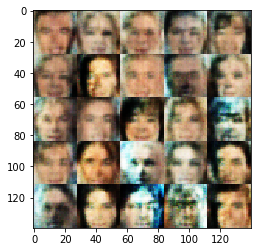

Epoch 1/1... Batch 1610... Discriminator Loss: 0.7885... Generator Loss: 1.7315
Epoch 1/1... Batch 1620... Discriminator Loss: 0.7017... Generator Loss: 1.5026
Epoch 1/1... Batch 1630... Discriminator Loss: 0.7969... Generator Loss: 1.0443
Epoch 1/1... Batch 1640... Discriminator Loss: 0.5562... Generator Loss: 1.8812
Epoch 1/1... Batch 1650... Discriminator Loss: 0.5213... Generator Loss: 1.8169
Epoch 1/1... Batch 1660... Discriminator Loss: 0.7921... Generator Loss: 1.0337
Epoch 1/1... Batch 1670... Discriminator Loss: 0.7726... Generator Loss: 1.9993
Epoch 1/1... Batch 1680... Discriminator Loss: 0.8949... Generator Loss: 1.9813
Epoch 1/1... Batch 1690... Discriminator Loss: 0.6685... Generator Loss: 1.6737
Epoch 1/1... Batch 1700... Discriminator Loss: 0.7373... Generator Loss: 2.0501


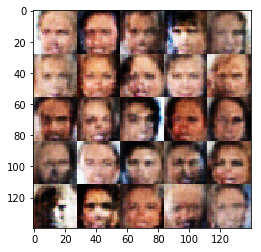

Epoch 1/1... Batch 1710... Discriminator Loss: 0.8332... Generator Loss: 2.6157
Epoch 1/1... Batch 1720... Discriminator Loss: 0.9284... Generator Loss: 1.9461
Epoch 1/1... Batch 1730... Discriminator Loss: 0.8598... Generator Loss: 2.2227
Epoch 1/1... Batch 1740... Discriminator Loss: 0.6761... Generator Loss: 1.8147
Epoch 1/1... Batch 1750... Discriminator Loss: 0.8756... Generator Loss: 1.3778
Epoch 1/1... Batch 1760... Discriminator Loss: 0.7730... Generator Loss: 1.6363
Epoch 1/1... Batch 1770... Discriminator Loss: 0.6502... Generator Loss: 1.4620
Epoch 1/1... Batch 1780... Discriminator Loss: 0.8403... Generator Loss: 1.2671
Epoch 1/1... Batch 1790... Discriminator Loss: 0.7267... Generator Loss: 1.9817
Epoch 1/1... Batch 1800... Discriminator Loss: 0.7390... Generator Loss: 1.5440


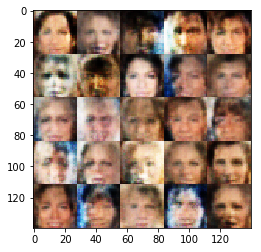

Epoch 1/1... Batch 1810... Discriminator Loss: 0.8035... Generator Loss: 1.6345
Epoch 1/1... Batch 1820... Discriminator Loss: 0.8625... Generator Loss: 1.5088
Epoch 1/1... Batch 1830... Discriminator Loss: 0.8080... Generator Loss: 1.7641
Epoch 1/1... Batch 1840... Discriminator Loss: 0.4754... Generator Loss: 2.0656
Epoch 1/1... Batch 1850... Discriminator Loss: 0.7311... Generator Loss: 1.6122
Epoch 1/1... Batch 1860... Discriminator Loss: 0.6739... Generator Loss: 1.7527
Epoch 1/1... Batch 1870... Discriminator Loss: 0.7708... Generator Loss: 1.4603
Epoch 1/1... Batch 1880... Discriminator Loss: 0.6907... Generator Loss: 1.2751
Epoch 1/1... Batch 1890... Discriminator Loss: 0.7358... Generator Loss: 1.2239
Epoch 1/1... Batch 1900... Discriminator Loss: 0.6472... Generator Loss: 1.7329


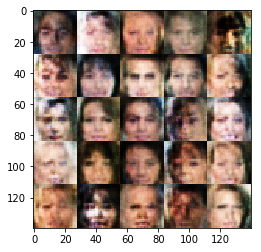

Epoch 1/1... Batch 1910... Discriminator Loss: 0.8182... Generator Loss: 1.4277
Epoch 1/1... Batch 1920... Discriminator Loss: 0.5375... Generator Loss: 1.8739
Epoch 1/1... Batch 1930... Discriminator Loss: 0.6884... Generator Loss: 1.4086
Epoch 1/1... Batch 1940... Discriminator Loss: 0.7804... Generator Loss: 1.6965
Epoch 1/1... Batch 1950... Discriminator Loss: 0.7634... Generator Loss: 1.7990
Epoch 1/1... Batch 1960... Discriminator Loss: 0.7320... Generator Loss: 1.4081
Epoch 1/1... Batch 1970... Discriminator Loss: 0.6612... Generator Loss: 1.4033
Epoch 1/1... Batch 1980... Discriminator Loss: 0.7886... Generator Loss: 2.0839
Epoch 1/1... Batch 1990... Discriminator Loss: 0.6603... Generator Loss: 1.7240
Epoch 1/1... Batch 2000... Discriminator Loss: 0.6829... Generator Loss: 1.5106


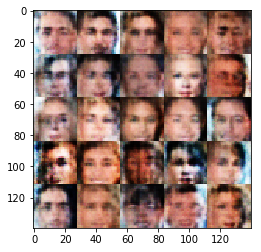

Epoch 1/1... Batch 2010... Discriminator Loss: 0.6736... Generator Loss: 1.3086
Epoch 1/1... Batch 2020... Discriminator Loss: 0.7876... Generator Loss: 1.8229
Epoch 1/1... Batch 2030... Discriminator Loss: 0.5468... Generator Loss: 1.9811
Epoch 1/1... Batch 2040... Discriminator Loss: 0.6500... Generator Loss: 1.2741
Epoch 1/1... Batch 2050... Discriminator Loss: 0.7449... Generator Loss: 1.7601
Epoch 1/1... Batch 2060... Discriminator Loss: 0.5796... Generator Loss: 1.6754
Epoch 1/1... Batch 2070... Discriminator Loss: 0.6791... Generator Loss: 1.4367
Epoch 1/1... Batch 2080... Discriminator Loss: 0.8833... Generator Loss: 1.1715
Epoch 1/1... Batch 2090... Discriminator Loss: 0.6213... Generator Loss: 1.9879
Epoch 1/1... Batch 2100... Discriminator Loss: 0.6553... Generator Loss: 1.5650


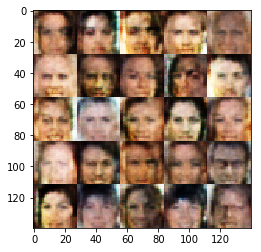

Epoch 1/1... Batch 2110... Discriminator Loss: 0.8988... Generator Loss: 1.3712
Epoch 1/1... Batch 2120... Discriminator Loss: 0.8161... Generator Loss: 2.2079
Epoch 1/1... Batch 2130... Discriminator Loss: 0.7362... Generator Loss: 1.3183
Epoch 1/1... Batch 2140... Discriminator Loss: 0.8704... Generator Loss: 1.3003
Epoch 1/1... Batch 2150... Discriminator Loss: 0.7461... Generator Loss: 1.2624
Epoch 1/1... Batch 2160... Discriminator Loss: 0.8841... Generator Loss: 1.5004
Epoch 1/1... Batch 2170... Discriminator Loss: 0.8642... Generator Loss: 1.3012
Epoch 1/1... Batch 2180... Discriminator Loss: 0.8307... Generator Loss: 0.9011
Epoch 1/1... Batch 2190... Discriminator Loss: 0.7184... Generator Loss: 1.7488
Epoch 1/1... Batch 2200... Discriminator Loss: 0.7287... Generator Loss: 1.8203


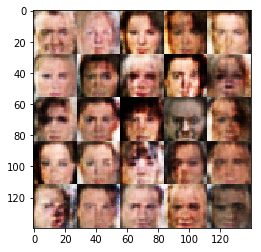

Epoch 1/1... Batch 2210... Discriminator Loss: 0.7634... Generator Loss: 1.7836
Epoch 1/1... Batch 2220... Discriminator Loss: 0.8724... Generator Loss: 1.8485
Epoch 1/1... Batch 2230... Discriminator Loss: 0.8497... Generator Loss: 2.1829
Epoch 1/1... Batch 2240... Discriminator Loss: 0.7788... Generator Loss: 2.0747
Epoch 1/1... Batch 2250... Discriminator Loss: 0.6812... Generator Loss: 1.6508
Epoch 1/1... Batch 2260... Discriminator Loss: 0.6133... Generator Loss: 1.5581
Epoch 1/1... Batch 2270... Discriminator Loss: 0.7240... Generator Loss: 1.6372
Epoch 1/1... Batch 2280... Discriminator Loss: 0.6220... Generator Loss: 1.5618
Epoch 1/1... Batch 2290... Discriminator Loss: 0.8343... Generator Loss: 1.8206
Epoch 1/1... Batch 2300... Discriminator Loss: 0.7772... Generator Loss: 1.0455


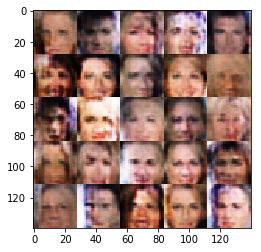

Epoch 1/1... Batch 2310... Discriminator Loss: 0.8028... Generator Loss: 1.6409
Epoch 1/1... Batch 2320... Discriminator Loss: 0.9364... Generator Loss: 1.7633
Epoch 1/1... Batch 2330... Discriminator Loss: 0.8209... Generator Loss: 1.6933
Epoch 1/1... Batch 2340... Discriminator Loss: 0.7466... Generator Loss: 1.6321
Epoch 1/1... Batch 2350... Discriminator Loss: 0.8332... Generator Loss: 1.4710
Epoch 1/1... Batch 2360... Discriminator Loss: 0.6760... Generator Loss: 2.1760
Epoch 1/1... Batch 2370... Discriminator Loss: 0.6427... Generator Loss: 1.5872
Epoch 1/1... Batch 2380... Discriminator Loss: 0.7277... Generator Loss: 1.5223
Epoch 1/1... Batch 2390... Discriminator Loss: 0.6472... Generator Loss: 1.4100
Epoch 1/1... Batch 2400... Discriminator Loss: 0.7528... Generator Loss: 1.2162


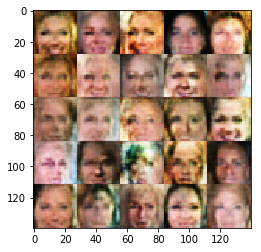

Epoch 1/1... Batch 2410... Discriminator Loss: 1.0041... Generator Loss: 1.9510
Epoch 1/1... Batch 2420... Discriminator Loss: 0.7027... Generator Loss: 1.3921
Epoch 1/1... Batch 2430... Discriminator Loss: 0.7014... Generator Loss: 1.2096
Epoch 1/1... Batch 2440... Discriminator Loss: 0.6121... Generator Loss: 1.7808
Epoch 1/1... Batch 2450... Discriminator Loss: 0.7202... Generator Loss: 1.5732
Epoch 1/1... Batch 2460... Discriminator Loss: 0.7077... Generator Loss: 1.6958
Epoch 1/1... Batch 2470... Discriminator Loss: 0.6866... Generator Loss: 2.0930
Epoch 1/1... Batch 2480... Discriminator Loss: 0.8735... Generator Loss: 1.3484
Epoch 1/1... Batch 2490... Discriminator Loss: 0.8269... Generator Loss: 1.4513
Epoch 1/1... Batch 2500... Discriminator Loss: 0.8381... Generator Loss: 1.2475


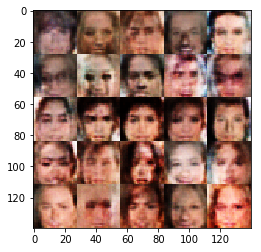

Epoch 1/1... Batch 2510... Discriminator Loss: 0.7825... Generator Loss: 1.2494
Epoch 1/1... Batch 2520... Discriminator Loss: 0.6282... Generator Loss: 1.3048
Epoch 1/1... Batch 2530... Discriminator Loss: 0.7045... Generator Loss: 1.6221
Epoch 1/1... Batch 2540... Discriminator Loss: 0.6530... Generator Loss: 1.3748
Epoch 1/1... Batch 2550... Discriminator Loss: 0.7612... Generator Loss: 1.2940
Epoch 1/1... Batch 2560... Discriminator Loss: 0.8343... Generator Loss: 1.5109
Epoch 1/1... Batch 2570... Discriminator Loss: 0.5227... Generator Loss: 1.9660
Epoch 1/1... Batch 2580... Discriminator Loss: 0.7187... Generator Loss: 1.5011
Epoch 1/1... Batch 2590... Discriminator Loss: 0.7367... Generator Loss: 1.7198
Epoch 1/1... Batch 2600... Discriminator Loss: 0.6944... Generator Loss: 1.7604


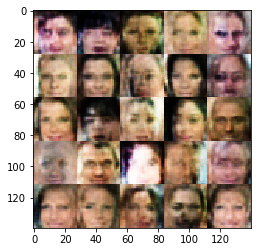

Epoch 1/1... Batch 2610... Discriminator Loss: 0.5377... Generator Loss: 2.0725
Epoch 1/1... Batch 2620... Discriminator Loss: 0.9526... Generator Loss: 0.8522
Epoch 1/1... Batch 2630... Discriminator Loss: 0.8961... Generator Loss: 0.9439
Epoch 1/1... Batch 2640... Discriminator Loss: 0.6563... Generator Loss: 1.7584
Epoch 1/1... Batch 2650... Discriminator Loss: 0.7600... Generator Loss: 1.0234
Epoch 1/1... Batch 2660... Discriminator Loss: 0.8002... Generator Loss: 1.5419
Epoch 1/1... Batch 2670... Discriminator Loss: 0.5721... Generator Loss: 1.4889
Epoch 1/1... Batch 2680... Discriminator Loss: 0.7240... Generator Loss: 1.6009
Epoch 1/1... Batch 2690... Discriminator Loss: 0.7312... Generator Loss: 1.4838
Epoch 1/1... Batch 2700... Discriminator Loss: 0.7895... Generator Loss: 1.7550


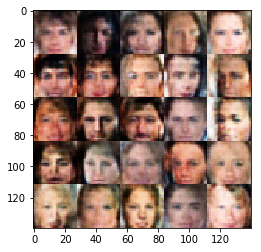

Epoch 1/1... Batch 2710... Discriminator Loss: 0.8467... Generator Loss: 1.3544
Epoch 1/1... Batch 2720... Discriminator Loss: 0.8266... Generator Loss: 1.6098
Epoch 1/1... Batch 2730... Discriminator Loss: 0.6717... Generator Loss: 1.5279
Epoch 1/1... Batch 2740... Discriminator Loss: 1.0475... Generator Loss: 0.7805
Epoch 1/1... Batch 2750... Discriminator Loss: 0.6561... Generator Loss: 1.7188
Epoch 1/1... Batch 2760... Discriminator Loss: 0.8867... Generator Loss: 1.3503
Epoch 1/1... Batch 2770... Discriminator Loss: 0.5922... Generator Loss: 2.0607
Epoch 1/1... Batch 2780... Discriminator Loss: 0.8225... Generator Loss: 1.4785
Epoch 1/1... Batch 2790... Discriminator Loss: 0.7539... Generator Loss: 1.2945
Epoch 1/1... Batch 2800... Discriminator Loss: 0.7255... Generator Loss: 1.9239


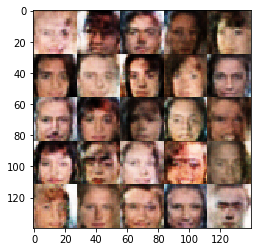

Epoch 1/1... Batch 2810... Discriminator Loss: 0.5539... Generator Loss: 1.6363
Epoch 1/1... Batch 2820... Discriminator Loss: 0.7809... Generator Loss: 2.0407
Epoch 1/1... Batch 2830... Discriminator Loss: 0.8297... Generator Loss: 1.5174
Epoch 1/1... Batch 2840... Discriminator Loss: 0.7753... Generator Loss: 1.4203
Epoch 1/1... Batch 2850... Discriminator Loss: 0.7570... Generator Loss: 1.7323
Epoch 1/1... Batch 2860... Discriminator Loss: 0.8024... Generator Loss: 1.4211
Epoch 1/1... Batch 2870... Discriminator Loss: 0.6308... Generator Loss: 2.0020
Epoch 1/1... Batch 2880... Discriminator Loss: 0.8798... Generator Loss: 0.7948
Epoch 1/1... Batch 2890... Discriminator Loss: 0.7541... Generator Loss: 1.0262
Epoch 1/1... Batch 2900... Discriminator Loss: 0.7335... Generator Loss: 1.1303


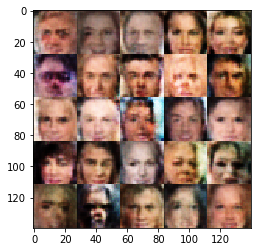

Epoch 1/1... Batch 2910... Discriminator Loss: 0.8129... Generator Loss: 1.1897
Epoch 1/1... Batch 2920... Discriminator Loss: 0.7969... Generator Loss: 1.8589
Epoch 1/1... Batch 2930... Discriminator Loss: 0.7903... Generator Loss: 1.3234
Epoch 1/1... Batch 2940... Discriminator Loss: 0.7672... Generator Loss: 1.0772
Epoch 1/1... Batch 2950... Discriminator Loss: 0.7292... Generator Loss: 1.6448
Epoch 1/1... Batch 2960... Discriminator Loss: 0.7130... Generator Loss: 1.5981
Epoch 1/1... Batch 2970... Discriminator Loss: 0.6335... Generator Loss: 1.6685
Epoch 1/1... Batch 2980... Discriminator Loss: 0.9198... Generator Loss: 1.5496
Epoch 1/1... Batch 2990... Discriminator Loss: 0.7539... Generator Loss: 1.7610
Epoch 1/1... Batch 3000... Discriminator Loss: 1.0322... Generator Loss: 1.1159


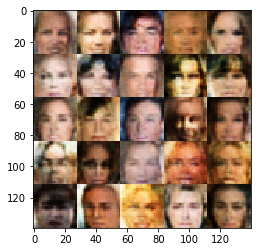

Epoch 1/1... Batch 3010... Discriminator Loss: 0.7581... Generator Loss: 1.2311
Epoch 1/1... Batch 3020... Discriminator Loss: 0.6824... Generator Loss: 2.2028
Epoch 1/1... Batch 3030... Discriminator Loss: 0.7666... Generator Loss: 1.5869
Epoch 1/1... Batch 3040... Discriminator Loss: 0.8409... Generator Loss: 1.5527
Epoch 1/1... Batch 3050... Discriminator Loss: 0.7302... Generator Loss: 1.7516
Epoch 1/1... Batch 3060... Discriminator Loss: 0.6798... Generator Loss: 1.5933
Epoch 1/1... Batch 3070... Discriminator Loss: 0.6980... Generator Loss: 1.6760
Epoch 1/1... Batch 3080... Discriminator Loss: 0.6903... Generator Loss: 1.6116
Epoch 1/1... Batch 3090... Discriminator Loss: 0.6778... Generator Loss: 1.6836
Epoch 1/1... Batch 3100... Discriminator Loss: 0.6656... Generator Loss: 1.2870


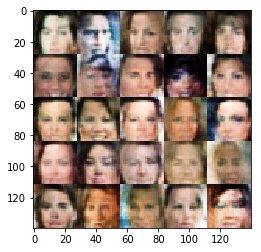

Epoch 1/1... Batch 3110... Discriminator Loss: 0.7952... Generator Loss: 1.5509
Epoch 1/1... Batch 3120... Discriminator Loss: 1.1171... Generator Loss: 0.6310
Epoch 1/1... Batch 3130... Discriminator Loss: 0.6179... Generator Loss: 1.5119
Epoch 1/1... Batch 3140... Discriminator Loss: 0.7101... Generator Loss: 1.2576
Epoch 1/1... Batch 3150... Discriminator Loss: 0.6302... Generator Loss: 1.4367
Epoch 1/1... Batch 3160... Discriminator Loss: 0.7142... Generator Loss: 1.1679


In [29]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.